In [ ]:
from geosyspy import Geosys
import os
from dotenv import load_dotenv
import datetime as dt
from dateutil.relativedelta import relativedelta
import logging
from geosyspy.utils.constants import *
from IPython.display import Image, display

logger = logging.getLogger('geosyspy')
logger.setLevel(logging.DEBUG)

# read .env file
load_dotenv()

API_CLIENT_ID = os.getenv('API_CLIENT_ID')
API_CLIENT_SECRET = os.getenv('API_CLIENT_SECRET')
API_USERNAME = os.getenv('API_USERNAME')
API_PASSWORD = os.getenv('API_PASSWORD')

client = Geosys(API_CLIENT_ID, API_CLIENT_SECRET, API_USERNAME, API_PASSWORD, Env.PREPROD, Region.NA)

polygon = "POLYGON((-91.17523978603823 40.29787117039518,-91.17577285022956 40.29199489606421,-91.167613719932 40.29199489606421,-91.1673028670095 40.29867040193312,-91.17523978603823 40.29787117039518))"
today = dt.date.today()
year_ago = dt.date.today() + relativedelta(months=-12)

# available crop codes of the connected user
crops = client.get_available_crops()


In [21]:
# Get coverage for the polygon
coverage_info_df, images_references = client.get_satellite_coverage_image_references(year_ago, today, collections=[SatelliteImageryCollection.SENTINEL_2, SatelliteImageryCollection.LANDSAT_8, SatelliteImageryCollection.LANDSAT_9],polygon=polygon)
coverage_info_df

2024-04-26 15:14:05,332 - geosyspy.services.map_product_service - INFO - Calling APIs for coverage


,coveragePercent,maps,image.id,image.availableBands,image.sensor,image.spatialResolution,image.date,seasonField.id
0,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",sentinel-2-l2a|S2B_15TXE_20240412_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-04-12T17:02:33Z,6ljb5l5
1,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",sentinel-2-l2a|S2A_15TXE_20240407_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-04-07T17:02:31Z,6ljb5l5
2,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",sentinel-2-l2a|S2A_15TXE_20240328_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-03-28T17:02:33Z,6ljb5l5
3,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",sentinel-2-l2a|S2B_15TXE_20240323_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-03-23T17:02:33Z,6ljb5l5
4,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",sentinel-2-l2a|S2B_15TXE_20240303_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-03-03T17:02:29Z,6ljb5l5
5,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",sentinel-2-l2a|S2B_15TXE_20240222_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-02-22T17:02:33Z,6ljb5l5
6,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",sentinel-2-l2a|S2B_15TXE_20240212_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-02-12T17:02:33Z,6ljb5l5
7,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",landsat-c2l2-sr|LC08_L2SP_024032_20231212_2023...,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",LANDSAT_8,30.0,2023-12-12T16:41:50Z,6ljb5l5
8,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",landsat-c2l2-sr|LC08_L2SP_025032_20231117_2023...,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",LANDSAT_8,30.0,2023-11-17T16:48:04Z,6ljb5l5
9,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'INSEA...",landsat-c2l2-sr|LC08_L2SP_025032_20230914_2023...,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",LANDSAT_8,30.0,2023-09-14T16:47:54Z,6ljb5l5


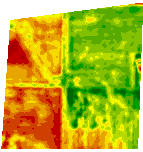

In [23]:
# get product from coverage
season_field_id = '6ljb5l5'
image_id = 'sentinel-2-l2a|S2B_15TXE_20240412_0_L2A'
indicator = 'INSEASON_NDVI'
image_extension = ".png"
product = client.get_product(season_field_id, image_id, indicator, image_extension)
if image_extension is not None:
    display(Image("output" + image_extension))
else:
    display(product)

In [ ]:
# Get aggregated NDVI time series
client.get_time_series(year_ago, today, collection=SatelliteImageryCollection.MODIS, indicators=["NDVI"],polygon=polygon)

In [ ]:
# Get aggregated EVI time series
client.get_time_series(year_ago, today, collection=SatelliteImageryCollection.MODIS, indicators=["EVI"], polygon=polygon)

In [ ]:
# Get aggregated 'Forecast daily' time series
indicators = ['Precipitation', 'Temperature','Date']
point = "POINT (0.0872845021171696 43.69457564315705)"
client.get_time_series(dt.date.today(), dt.date.today() + relativedelta(days=+5), collection=WeatherTypeCollection.WEATHER_FORECAST_DAILY, indicators=indicators,polygon=point)

In [ ]:
# Get aggregated 'Forecast hourly' time series
indicators = ['Precipitation', 'Temperature']
point = "POINT (0.0872845021171696 43.69457564315705)"
client.get_time_series(dt.date.today(), dt.date.today() + relativedelta(days=+2), collection=WeatherTypeCollection.WEATHER_FORECAST_HOURLY, indicators=indicators, polygon=point)

In [ ]:
# Get aggregated 'Historical daily' time series
indicators = ['Precipitation', 'Temperature']
start_date = dt.datetime.strptime("2022-01-01", "%Y-%m-%d")
end_date = dt.datetime.strptime("2022-02-01", "%Y-%m-%d")
client.get_time_series(start_date, end_date, collection=WeatherTypeCollection.WEATHER_HISTORICAL_DAILY, indicators=indicators,polygon=polygon)

In [ ]:
# Get satellite image time series for Modis NDVI
client.get_satellite_image_time_series(year_ago, today, collections=[SatelliteImageryCollection.MODIS], indicators=["NDVI"], polygon=polygon)

In [ ]:
# Get satellite image time series for LANDSAT_8 and SENTINEL_2 Reflectance
time_series_xarr = client.get_satellite_image_time_series(year_ago, today, collections=[SatelliteImageryCollection.SENTINEL_2, SatelliteImageryCollection.LANDSAT_8], indicators=["Reflectance"],polygon=polygon)
time_series_xarr


In [ ]:

import xarray as xr
# Get satellite image time series for LANDSAT_8 and SENTINEL_2 NDVI 
# list of available indicators: Reflectance, NDVI, EVI, GNDVI, NDWI, CVI, CVIn, LAI
ndvi_time_series_xarr = client.get_satellite_image_time_series(year_ago, today, collections=[SatelliteImageryCollection.SENTINEL_2, SatelliteImageryCollection.LANDSAT_8], indicators=["ndvi"], polygon=polygon)

ndvi_time_series_xarr


In [ ]:
lai_time_series_xarr = client.get_satellite_image_time_series(year_ago, today, collections=[SatelliteImageryCollection.SENTINEL_2, SatelliteImageryCollection.LANDSAT_8], indicators=["NDWI"],polygon=polygon)
lai_time_series_xarr

In [ ]:
if ndvi_time_series_xarr.coords == lai_time_series_xarr.coords:
    print("Les dimensions sont identiques.")
else:
    print("Les dimensions ne sont pas identiques.")
    print(ndvi_time_series_xarr.coords)
    print(lai_time_series_xarr.coords)


datacube = xr.merge([ndvi_time_series_xarr, lai_time_series_xarr])

datacube.to_zarr("result.zarr")

In [ ]:
# Display cumulative NDVI from last result

import numpy as np
import matplotlib.pyplot as plt

polygon_ndvi_ds = ndvi_time_series_xarr['ndvi'].sortby('time')
time_coords = polygon_ndvi_ds['time']

# exclude Nan values to caluculate mean
masked_dataarray = polygon_ndvi_ds.where(~np.isnan(polygon_ndvi_ds))

# NDVI mean calculattion
mean_ndvi = masked_dataarray.mean(dim=['x', 'y'])

# Cumulative NDVI calculation 
polygon_cumul_ndvi = mean_ndvi.cumsum(dim='time')
polygon_cumul_ndvi 

# build & display cumlative Ndvi graph
plt.plot(time_coords, polygon_cumul_ndvi)
plt.xlabel('Time')
plt.ylabel('NDVI Cumul')
plt.title('NVDI Cumul by date')
plt.show()

In [ ]:
import matplotlib
time_series_xarr.reflectance.clip(0,1).sel(band='Green').plot(x="x", y="y", col="time", col_wrap=3, figsize=(20,20))

In [ ]:
images_references

In [ ]:
# Download and save a specific image
client.download_image(images_references[('2023-05-03', 'SENTINEL_2')])


In [ ]:
# Define a data schema in Analytics Fabrics
schema = {
    "NDVI": "double"
}
schema_id = "GeosysPy_NDVI"
client.create_schema_id(schema_id, schema)

In [ ]:
# Get metrics in Analytics Fabric

start_date = dt.datetime.strptime("2022-01-24", "%Y-%m-%d")
end_date = dt.datetime.strptime("2022-03-01", "%Y-%m-%d")
schema_id = "LAI_RADAR"
polygon = "POLYGON((-52.72591542 -18.7395779,-52.72604885 -18.73951122,-52.72603114 -18.73908689,-52.71556835 -18.72490316,-52.71391916 -18.72612966,-52.71362802 -18.72623726,-52.71086473 -18.72804231,-52.72083542 -18.74173696,-52.72118937 -18.74159174,-52.72139229 -18.7418552,-52.72600257 -18.73969719,-52.72591542 -18.7395779))"
client.get_metrics( schema_id, start_date, end_date,polygon=polygon)

In [ ]:
# Get time serie
start_date = dt.datetime.strptime("2018-12-30", "%Y-%m-%d")
end_date = dt.datetime.strptime("2019-12-31", "%Y-%m-%d")
df = client.get_time_series(start_date, end_date, collection=SatelliteImageryCollection.MODIS, indicators=["NDVI"],polygon=polygon)
df.head()

In [ ]:
# Create structure before push values in Analytics Fabrics
values = []
for i in range(0,len(df)):
    prop = {
        "Timestamp": str(df["value"].index[i]),
        "Values": {
            "NDVI": df["value"].values[i]
        }
        }
    values.append(prop)
values[0:5]

In [ ]:
# Push metrics in Analytics Fabrics
schema_id = "GeosysPy_NDVI"
client.push_metrics(schema_id, values, polygon=polygon)

In [ ]:
# Get metrics in Analytics Fabrics
start_date = dt.datetime.strptime("2018-01-01", "%Y-%m-%d")
end_date = dt.datetime.strptime("2022-04-01", "%Y-%m-%d")
client.get_metrics(schema_id, start_date, end_date, polygon=polygon)

In [ ]:
start_date="2020-10-09"
end_date="2022-10-09"
sensors=["Sentinel_2", "Landsat_8"]
denoiser=True
smoother="ww"
eoc=True
aggregation="mean"
index="ndvi"
raw_data=True
str_polygon="POLYGON ((-0.49881816 46.27330504, -0.49231649 46.27320122, -0.49611449 46.26983426, -0.49821735 46.27094671, -0.49881816 46.27330504))"

str_s3_path = client.get_mr_time_series(str_polygon, start_date, end_date, sensors, denoiser, smoother, eoc, aggregation, index, raw_data)
str_s3_path

In [ ]:
str_polygon="POLYGON ((-0.49881816 46.27330504, -0.49231649 46.27320122, -0.49611449 46.26983426, -0.49821735 46.27094671, -0.49881816 46.27330504))"

str_s3_path = client.get_mr_time_series(str_polygon)
str_s3_path

In [ ]:
from notebook_utils import *

# read MRTS outputs from AWS and plot result
dict_mrts = read_mrts_from_awsS3(str_s3_path)
plot_mrts_dict(dict_mrts)

### others useful functions
# plot_mrts_from_aws(str_s3_path) : plot MRTS outputs from AWS
# download MRTS outputs from AWS and read outputs downloaded : download_s3_files(str_s3_path), read_mrts_data(str_downloaded_path)

## AGRIQUEST COMPUTATION

In [ ]:
# Generate a panda data frame from Agriquest Weather Data:
# on all AMU of o block
# on a specific period
# for a specific weather indicator
aq_weather_data_frame = client.get_agriquest_weather_block_data(start_date="2022-06-01",
                                                  end_date="2023-06-10",
                                                  block_code=AgriquestBlocks.AMU_NORTH_AMERICA,
                                                  weather_type=AgriquestWeatherType.AVERAGE_TEMPERATURE)

aq_weather_data_frame

In [ ]:
# Generate a panda data frame from Agriquest NDVI Data:
# on all AMU of o block
# on a specific date
# for a specific commodity (ALL_VEGETATION or ALL_CROPS)

aq_ndvi_data_frame = client.get_agriquest_ndvi_block_data(day_of_measure="2022-06-01",
                                               commodity_code=AgriquestCommodityCode.ALL_CROPS,             
                                               block_code=AgriquestBlocks.FRA_DEPARTEMENTS)

aq_ndvi_data_frame

## ANALYTICS COMPUTATION

In [ ]:
# Analytics processor - Historical Harvest
harvest_historical_analytics = client.get_harvest_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops._2ND_CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    harvest_type=Harvest.HARVEST_HISTORICAL)
harvest_historical_analytics


In [ ]:
# Analytics processor - Inseason Harvest
harvest_in_season_analytics = client.get_harvest_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops._2ND_CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    harvest_type=Harvest.HARVEST_IN_SEASON)

harvest_in_season_analytics


In [ ]:
# Analytics processor - Inseason Emergence
emergence_in_season_analytics = client.get_emergence_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops._2ND_CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    emergence_type=Emergence.EMERGENCE_IN_SEASON)

emergence_in_season_analytics


In [ ]:
# Analytics processor - Historical Emergence
emergence_historical_analytics = client.get_emergence_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops._2ND_CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    emergence_type=Emergence.EMERGENCE_HISTORICAL)

emergence_historical_analytics


In [ ]:
# Analytics processor - Emergence Delay
emergence_delay_analytics = client.get_emergence_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops.CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    emergence_type=Emergence.EMERGENCE_DELAY)

emergence_delay_analytics


In [ ]:
# Analytics processor - Potential Score
potential_score_analytics = client.get_potential_score_analytics(
    end_date = "2022-03-06",
    nb_historical_years = 5,
    season_duration = 200, 
    season_start_day = 1, 
    season_start_month = 10, 
    crop = crops.CORN,
    sowing_date = "2021-10-01",
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

potential_score_analytics

In [ ]:
# Analytics processor - Greenness
greenness_analytics = client.get_greenness_analytics(
    start_date ="2022-01-15",
    end_date = "2022-05-31",    
    crop = crops.CORN,
    sowing_date = "2022-01-15",
    # WKT
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
    # GeoJson
    #geometry='{"type": "Polygon","coordinates": [[[ -54.260277780000003, -25.387777780000000 ],[ -54.260277780000003, -25.374444440000001 ],[ -54.259999999999998, -25.374166670000001 ],[ -54.259722220000000, -25.374444440000001 ],[ -54.259444440000003, -25.374444440000001 ],[ -54.258888890000001, -25.374722219999999 ],[ -54.258611110000004, -25.374722219999999 ],[ -54.258888890000001, -25.375000000000000 ],[ -54.258888890000001, -25.375555550000001 ],[ -54.258611110000004, -25.376111110000000 ],[ -54.258611110000004, -25.381944440000002 ],[ -54.258333329999999, -25.384166669999999 ],[ -54.256944439999998, -25.383611110000000 ],[ -54.256944439999998, -25.384166669999999 ],[ -54.257500000000000, -25.384166669999999 ],[ -54.257500000000000, -25.384444439999999 ],[ -54.257777779999998, -25.384166669999999 ],[ -54.258070160000003, -25.384158120000002 ],[ -54.258055560000003, -25.384444439999999 ],[ -54.258077300000004, -25.384722060000001 ],[ -54.257500000000000, -25.385277779999999 ],[ -54.256944439999998, -25.385000000000002 ],[ -54.256388890000004, -25.383611110000000 ],[ -54.254722219999998, -25.383055550000002 ],[ -54.254722219999998, -25.382500000000000 ],[ -54.254166670000004, -25.381944440000002 ],[ -54.254444440000000, -25.381666670000001 ],[ -54.254722219999998, -25.381666670000001 ],[ -54.254722219999998, -25.379444440000000 ],[ -54.252777780000002, -25.379444440000000 ],[ -54.252777780000002, -25.385833330000001 ],[ -54.254192230000001, -25.386153900000000 ],[ -54.253906700000002, -25.385892160000001 ],[ -54.253888889999999, -25.385000000000002 ],[ -54.254444440000000, -25.385555549999999 ],[ -54.254787100000001, -25.385820770000002 ],[ -54.254722219999998, -25.386111110000002 ],[ -54.260277780000003, -25.387777780000000 ]]]}',
)

greenness_analytics

In [ ]:
# Analytics processor - Harvest Readiness
harvest_readiness_analytics = client.get_harvest_readiness_analytics(
    start_date ="2022-01-15",
    end_date = "2022-05-31",    
    crop = crops.CORN,
    sowing_date = "2022-01-15",
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

harvest_readiness_analytics

In [ ]:
# Analytics processor - Planted area
planted_area_analytics = client.get_planted_area_analytics(
    start_date ="2022-01-15",
    end_date = "2022-05-31",        
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

planted_area_analytics

In [ ]:
# Analytics processor - zarc
zarc_analytics = client.get_zarc_analytics(
    start_date_emergence= "2022-01-15",
    end_date_emergence = "2022-05-31",
    nb_days_sowing_emergence = 20,
    crop =crops.CORN,    
    soil_type = ZarcSoilType.NONE,
    cycle = ZarcCycleType.NONE,    
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

zarc_analytics

In [ ]:
# Analytics processor - crop id
brazil_crop_id_analytics = client.get_brazil_crop_id_analytics(
    start_date ="2020-10-01",
    end_date = "2021-05-31",    
    season = CropIdSeason.SEASON_1,
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

brazil_crop_id_analytics

In [ ]:
import pandas as pd

# Display probability by crop value from last zarc analytics result
data_dict = eval(brazil_crop_id_analytics.values[0][1])
df_new = pd.DataFrame.from_records([data_dict])
df_new
